In [1]:
# Import statements
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import urllib.request # to import images from dataset
import sys

from sklearn.model_selection import train_test_split

In [2]:
# Import Neural Network and PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


### **Importing data**

In [4]:
df = pd.read_csv('/kaggle/input/fakeddit-dataset/multimodal_only_samples/multimodal_train.tsv', sep='\t')

1. Remove the columns for "2-way" and "3-way" classification
2. Remove the column "title" since we already have the "clear_title" column

In [5]:
df.drop(['6_way_label', '3_way_label', 'title'], axis=1, inplace=True)

In [6]:
df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,2_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,0.84,1
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,0.99,0
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,0.92,1
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,0.95,1
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,0.84,0


In [7]:
df.shape

(564000, 13)

- Apply `train_test_split()` to minimize dataset with over 564.000 samples.

- Split the dataset and only use 5% data to train (because of limited resources).

- Stratify function is applied in order to maintain the same class sample distribution (percentage) from original Fakeddit source dataset.

In [8]:
df, _ = train_test_split(
    df,
    test_size=0.97,
    shuffle=True,
    stratify=df["2_way_label"]
)

In [9]:
df.shape

(16920, 13)

### **Data visualization**

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
# Check for Nan values
print("clean_title:", df["clean_title"].isnull().sum())
print("has_image:", df["hasImage"].isnull().sum())
print("id:", df["id"].isnull().sum())

# Check how many rows with the column "hasImage" is false
print("\n", df["hasImage"].value_counts())

clean_title: 0
has_image: 0
id: 0

 hasImage
True    16920
Name: count, dtype: int64


**Plot the 6- Way Class Distribution of dataset:**
- 0: TRUE
- 1: SATIRE
- 2: FALSE CONNECTION
- 3: IMPOSTER CONTENT
- 4: MANIPULATED CONTENT
- 5: MISLEADING CONTENT

<Axes: title={'center': '2_way_label'}, ylabel='Frequency'>

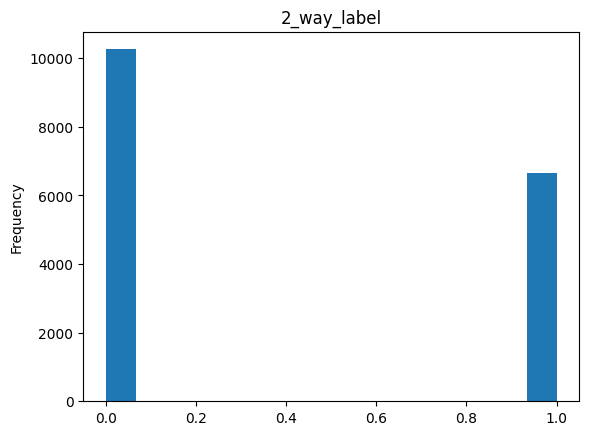

In [12]:
df["2_way_label"].plot(kind="hist", bins=15, title="2_way_label")

> Based on the class distribution graph above, the classes are not represented equally in the dataset.

### **Import images from URL into working directory**

- Used the `request` module from `urllib` library to handle the downloading of images from URLs.

- Any NaN values in the DataFrame are replaced with empty strings using `replace()` and `fillna()` methods. This ensures that there are no missing values when working with the data.

- Used `urlopen()` to download the image from the URL and write the content to a file. The file is saved with the id of the row and the extension .jpg, to enable easy future access

- Some image URLs do not exist anymore/ have been taken down, the corresponding rows are dropped from the DataFrame.

In [13]:
# from urllib import request

# # Replace NaN values with empty strings
# df = df.replace(np.nan, '', regex=True)
# df.fillna('', inplace=True)

# # Make a directory to download images into
# if not os.path.exists("/kaggle/working/images"):
#   os.makedirs("/kaggle/working/images")

# for index, row in df.iterrows():
#   if row["hasImage"] == True and row["image_url"] != "" and row["image_url"] != "nan":
#     image_url = row["image_url"]
#     path = "/kaggle/working/images/" + row["id"] + ".jpg"

#     try:
#       f = open(path, 'wb')
#       f.write(request.urlopen(image_url).read())
#       f.close()

#     except:
#         # To account for now invalid image urls
#         df.drop(index=index, axis=0, inplace=True)
#         pass

# print("Downloaded all images.")
# df.reset_index(drop=True, inplace=True)

In [14]:
import os
import numpy as np
import pandas as pd
from urllib import request
from concurrent.futures import ThreadPoolExecutor, as_completed

# Ensure df is defined (for testing, replace with actual DataFrame loading)
# df = pd.read_csv("your_file.csv")

# Replace NaN values with empty strings
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Create the directory to store images if it doesn't exist
image_dir = "/kaggle/working/images"
os.makedirs(image_dir, exist_ok=True)

# Function to download a single image
def download_image(row):
    image_url = row["image_url"]
    image_path = os.path.join(image_dir, f"{row['id']}.jpg")

    # Skip if image already exists
    if os.path.exists(image_path):
        return True  

    try:
        # Download and save the image
        with open(image_path, 'wb') as f:
            f.write(request.urlopen(image_url, timeout=10).read())
        return True  
    except Exception:
        return False  # Failed download

# Function to process a single row in the dataframe
def process_row(index, row):
    if row["hasImage"] and row["image_url"] not in ["", "nan"]:
        success = download_image(row)
        if not success:
            return index  # Mark row for removal if download fails
    return None

# Use ThreadPoolExecutor to download images concurrently
failed_indices = []
with ThreadPoolExecutor(max_workers=10) as executor:  
    futures = {executor.submit(process_row, index, row): index for index, row in df.iterrows()}
    
    for future in as_completed(futures):
        try:
            failed_index = future.result()
            if failed_index is not None:
                failed_indices.append(failed_index)
        except Exception as exc:
            print(f"An error occurred for row {futures[future]}: {exc}")

# Remove failed rows from the dataframe
df.drop(index=failed_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Downloaded all images. Skipped {len(failed_indices)} failed downloads.")


Downloaded all images. Skipped 5550 failed downloads.


In [15]:
# # Plotting images to test download
# for i in range(5):
#     path = "/kaggle/working/images/" + df["id"][i] + ".jpg"

#     im= np.array(Image.open(path))

#     print(im.shape)
#     ax= plt.subplot(121)
#     ax.imshow(im)

#     plt.show()

In [16]:
# import matplotlib.pyplot as plt
# from PIL import Image

# # Load the RGBA image
# image_path = "/kaggle/working/images/" + df["id"][0] + ".jpg"
# image = Image.open(image_path).convert("RGB")

# # Split the image into individual channels
# r, g, b = image.split()

# # Plot each channel separately
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 4, 1)
# plt.imshow(r)
# plt.title('Red Channel')

# plt.subplot(1, 4, 2)
# plt.imshow(g)
# plt.title('Green Channel')

# plt.subplot(1, 4, 3)
# plt.imshow(b)
# plt.title('Blue Channel')

# #plt.subplot(1, 4, 4)
# #plt.imshow(a)
# #plt.title('Alpha Channel')

# plt.tight_layout()
# plt.show()

**There are images of different sizes which will not work for CNN:**
- Check for corrupt image files to avoid errors
- Resize images to (256, 256, 3)
- Test 

> While attempting to resize images, there are errors with some corrupt image files (presumably downloaded from now-defunct links) so I run through image dataset to ensure all images can be successfully opened, else I dropped the corresponding rows from the Dataframe.

In [17]:
def validate_images(directory):
    corrupted_files = []

    # Walk through directory and sub-directories
    for index, row in df.iterrows():
      image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
      try:
          with Image.open(image_path) as img:
              img.verify()
      except Exception as e:
          corrupted_files.append(image_path)
          # print(f"Error with {image_path}: {e}")
          df.drop(index=index, axis=0, inplace=True)

    return corrupted_files


# Example usage:
directory = "/kaggle/working/images/"
corrupted_images = validate_images(directory)
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images.")
else:
    print("All images are valid!")
df.reset_index(drop=True, inplace=True)

Found 47 corrupted images.


Resized all the images in dataset to a standard size of (256, 256) using PyTorch's `torchvision.transforms`. The resized images overwrite the original ones.
- Each image is converted to RGB format to ensure consistent color channels.
- Used PyTorch's `torchvision.transforms.v2.Resize` to resize the image to the specified new_size.
- This is so I can pass all the images as uniform (256, 256, 3) matrixes in the CNN.

In [18]:
# Resize all images to (256, 256, 3)
new_size = (256, 256)

for index, row in df.iterrows():
    image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
    image = Image.open(image_path).convert("RGB")
    
    resize_transform = v2.Resize(new_size)
    resized_image = resize_transform(image)
    resized_image.save(image_path)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
# # Plotting images to test resize
# for i in range(5):
#     path = "/kaggle/working/images/" + df["id"][i] + ".jpg"

#     im = np.array(Image.open(path))

#     print(im.shape)
#     ax = plt.subplot(121)
#     ax.imshow(im)

#     plt.show()

### **Define Bert tokenizer to convert "clean_title" strings to uniform 768-element arrays**

- Use pre-trained BERT model from the Hugging Face `transformers` library to generate embeddings.
- BERT-Large Uncased model has a feed-forward network of 1024 hidden dimensions which results in a uniform length array.

In [20]:
!pip install --quiet transformers

In [21]:
from transformers import BertModel, BertTokenizer


model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states=True)

# Put the model in evaluation mode, which turns off dropout regularization which is used in training.
bert_model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [22]:
def get_bert_embedding(text):
    inputs = tokenizer.encode_plus(
        text, add_special_tokens=True,
        return_tensors="pt",
        max_length=80,
        truncation=True,
        padding="max_length"
    )
    
    return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)


# Test embedding
text = "this is an embedding example for fake news detection"
input_ids, attention_mask = get_bert_embedding(text=text)
print(input_ids.shape)
print(attention_mask.shape)
print(input_ids)
print(attention_mask)

torch.Size([80])
torch.Size([80])
tensor([  101,  2023,  2003,  2019,  7861,  8270,  4667,  2742,  2005,  8275,
         2739, 10788,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


### **Load and process input data**

In [23]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["2_way_label"]
)

df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test["2_way_label"]
)

Create FakedditDataset class:
- Apply transforms to images
- Returns:
    - `Image` in form of tensor
    - BERT tokenizer `input_ids` and `attention_mask`
    - Corresponding `6_way_label`

In [24]:
# class FakedditDataset(Dataset):
#     def __init__(self, df, text_field="clean_title", label_field="6_way_label", image_id="id"):
#         self.df = df.reset_index(drop=True)
#         self.text_field = text_field
#         self.label_field = label_field
#         self.image_id = image_id
        
#         self.image_size = (256, 256)
#         # Using the pre-calculated ImageNet mean and std values for normalization
#         self.mean, self.std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        
#         self.transform_func = v2.Compose([
#             v2.Resize(self.image_size),
#             v2.ToImage(),
#             v2.ToDtype(torch.float32, scale=True),
# #             v2.Normalize(self.mean, self.std)
#         ])
        
#     def __getitem__(self, index):
#         text = str(self.df.at[index, self.text_field])
#         label = self.df.at[index, self.label_field]
        
#         image_path = "/kaggle/working/images/" + self.df.at[index, self.image_id] + ".jpg"
#         image = Image.open(image_path)
#         image = self.transform_func(image)
        
#         input_ids, attention_mask = get_bert_embedding(text)
        
#         return image, input_ids, attention_mask, label
        
        
#     def __len__(self):
#         return self.df.shape[0]

In [25]:
class FakedditDataset(Dataset):
    def __init__(self, df, text_field="clean_title", label_field="2_way_label", 
                 image_id="id", is_training=True):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field
        self.image_id = image_id
        self.is_training = is_training
        
        # Training augmentations
        if is_training:
            self.transform_func = v2.Compose([
                v2.Resize((256, 256)),            # Resize to a slightly larger size for random cropping
                v2.RandomCrop((224, 224)),          # Crop to the expected 224x224 resolution for SigLIP
                v2.RandomHorizontalFlip(),          # Data augmentation: horizontal flip
                v2.ColorJitter(brightness=0.2, contrast=0.2),  # Random color adjustments
                v2.ToImage(),                     # Ensure image format
                v2.ToDtype(torch.float32, scale=True),  # Convert to float and scale pixel values
                v2.Normalize([0.485, 0.456, 0.406],  # Normalize using ImageNet stats (adjust if necessary)
                             [0.229, 0.224, 0.225])
            ])
        else:
            self.transform_func = v2.Compose([
                v2.Resize((224, 224)),            # Directly resize to 224x224 for validation/test
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
            ])
            
            
    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]
        
        image_path = "/kaggle/working/images/" + self.df.at[index, self.image_id] + ".jpg"
        image = Image.open(image_path)
        image = self.transform_func(image)
        
        input_ids, attention_mask = get_bert_embedding(text)
        
        return image, input_ids, attention_mask, label, index
        
        
    def __len__(self):
        return self.df.shape[0]

In [26]:
train_data = FakedditDataset(df_train)
val_data = FakedditDataset(df_val, is_training=False)
test_data = FakedditDataset(df_test, is_training=False)

In [27]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

# Verify if dataset is created accurately
image, input_ids, attention_mask, label, indices = next(iter(train_loader))
print(input_ids.shape, attention_mask.shape, label.shape, image.shape, indices.shape)

torch.Size([16, 80]) torch.Size([16, 80]) torch.Size([16]) torch.Size([16, 3, 224, 224]) torch.Size([16])


### Training and evaluate the model

- **Loss function:** `Weighted Cross Entropy Loss` with softmax activation function to return final probability.
    - Apply the `compute_class_weight` to calculate percentage values per class for a weighted CrossEntropy. Since some classes have considerably more samples than others, all classes are weighted and taken as input into the loss calculation according to their respective number of samples
- **Early stopping:** Stop training if loss is increasing.
- **Optimizer:** Adam
- **Learning rate:** 1e-4
- **Epochs:** 10

In [28]:
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [55]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=5, verbose=True)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for img, input_ids, attention_mask, label, indices in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device).float()  # Ensure label is float for BCE
            img = img.to(device)
                
            optimizer.zero_grad()

            # Forward pass and squeeze the extra dimension
            outputs = model(img, input_ids, attention_mask)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, label)

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * img.size(0)
            
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        with torch.no_grad():
            for img, input_ids, attention_mask, label, indices in val_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device).float()
                img = img.to(device)
    
                outputs = model(img, input_ids, attention_mask)
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, label)
                val_loss += loss.item() * img.size(0)

                # Use sigmoid and threshold at 0.5 for binary prediction
                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct_preds += torch.sum(preds == label)

        val_loss = val_loss / len(val_loader.dataset)
        accuracy = correct_preds.double() / len(val_loader.dataset)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader.dataset):.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

In [56]:
from sklearn.metrics import precision_score, recall_score

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            labels = batch['label'].to(device).float()

            outputs = model(images, text_input_ids, text_attention_mask)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    print("Test Loss:", total_loss/len(test_loader))

### **Build multimodal BERT + ResNet50**

In [57]:
class BERTSigLIPClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(BERTSigLIPClassifier, self).__init__()
        
        # Image processing with SigLIP
        # Import SigLIP model from torchvision or transformers
        from transformers import AutoProcessor, AutoModel
        
        # SigLIP model
        self.image_processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
        self.image_model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
        
        # Freeze early layers of SigLIP
        for i, (name, param) in enumerate(self.image_model.vision_model.named_parameters()):
            # Freeze all except the final transformer blocks
            if "encoder.layers" in name:
                layer_num = int(name.split("encoder.layers.")[1].split(".")[0])
                if layer_num < 10:  # Freeze first 10 layers (adjust as needed)
                    param.requires_grad = False
            elif "layernorm" not in name and "pooler" not in name:
                param.requires_grad = False
        
        # SigLIP vision embedding dimension is typically 768
        siglip_embedding_dim = self.image_model.vision_model.config.hidden_size
                    
        # Modify image branch with more regularization
        self.fc_image = nn.Sequential(
            nn.Linear(siglip_embedding_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate)
        )
        
        # Text processing
        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        # Freeze BERT layers except last few
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.encoder.layer[-2:].parameters():
            param.requires_grad = True
            
        # Modify text branch with more regularization
        self.fc_text = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate)
        )
        
        # Fusion and classification layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)
        )
        
    def forward(self, image, text_input_ids, text_attention_mask):
        # Image branch
        # SigLIP expects raw pixel values and handles preprocessing internally
        vision_outputs = self.image_model.vision_model(
            pixel_values=image,
            return_dict=True
        )
        x_img = vision_outputs.pooler_output  # Get the pooled image representation
        x_img = self.fc_image(x_img)
        
        # Text branch with attention-weighted pooling
        text_outputs = self.text_model(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            return_dict=True
        )
        
        # Attention-weighted pooling
        attention_weights = text_attention_mask.unsqueeze(-1).float()
        x_text = torch.sum(text_outputs.last_hidden_state * attention_weights, dim=1)
        x_text = x_text / torch.sum(attention_weights, dim=1)
        x_text = self.fc_text(x_text)
        
        # Maximum fusion (keeping the same fusion strategy you had)
        x_fused = torch.max(x_text, x_img)
        
        # Classification
        x_out = self.classifier(x_fused)
        return x_out


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

# Compute class weights from training labels
labels = df_train['2_way_label'].to_numpy()
# Compute weights for each class (0 and 1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# For BCEWithLogitsLoss, we use pos_weight for the positive class (class 1)
# pos_weight is expected to be a tensor of size [1]
pos_weight = torch.tensor([class_weights[1]], dtype=torch.float).to(device)

# Initialize your model (note: num_classes is set to 1 for binary classification)
model = BERTSigLIPClassifier(num_classes=1)
model = model.to(device)

# Define criterion using pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-5, factor=0.5, patience=1, verbose=True)
num_epochs = 10
train_model(model, train_loader,val_loader, criterion, optimizer, scheduler, num_epochs)
#print("\n")
evaluate_model(model, test_loader, criterion)

Epoch 1/10, Training Loss: 0.5293, Validation Loss: 0.4946, Accuracy: 0.7661


In [ ]:
torch.save(model.state_dict(), "model.pt")

# **Visualize prediction after training**

In [ ]:
# Assuming you already have a test/validation DataLoader
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for img, input_ids, attention_mask, label, indices in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        label = label.to(device)
        img = img.to(device)

        outputs = model(
              image = img,
              text_input_ids = input_ids,
              text_attention_mask = attention_mask
        )

        # Final Softmax layer returns class predictions per sample in batch
        # Highest probability value resembles class prediction and is assigned to preds variable
        _, preds = torch.max(outputs, dim=1)
        #print(outputs)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = [
    'TRUE', 
    "FALSE"
]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

> The model performs quite well on the `TRUE` AND `FALSE CONNECTION` classes but struggles with others.

### **Visualize the percentage of false predictions per class**

In [ ]:
import numpy as np

# Calculate false predictions for each class
total_per_class = np.sum(cm, axis=1)
correct_per_class = np.diagonal(cm)
false_per_class = total_per_class - correct_per_class

# Calculate percentage of false predictions per class
false_percentage_per_class = (false_per_class / total_per_class) * 100

# Display the results
for idx, class_name in enumerate(class_names):
    print(f"Class '{class_name}' - False Predictions: {false_percentage_per_class[idx]:.2f}%")


> The model's difficulty in classifying MISLEADING CONTENT and IMPOSTER CONTENT could stem from class imbalance

In [ ]:
total_per_class

In [ ]:
# Find class with most false predictions
max_false_class_idx = np.argmax(false_percentage_per_class)
print(f"Class with most false predictions: {class_names[max_false_class_idx]} ({false_percentage_per_class[max_false_class_idx]:.2f}%)")

In [ ]:
# Plot false prediction percentages as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, false_percentage_per_class, width=0.8, color='orange')
plt.ylabel('Percentage of False Predictions')
plt.xticks(rotation=45)
plt.title('False Predictions per Class')
plt.show()

### **Class distribution histogram**

In [ ]:
plt.hist(df_train["6_way_label"], bins=np.arange(len(class_names)+1) -0.5, rwidth=0.5)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title('Class Distribution in Training Set')
plt.show()

In [ ]:
import textwrap

def display_predictions(test_loader, model, device):
    """
    Displays 4 images per class with true labels, predicted labels, and clean titles
    """
    model.eval()
    
    # Initialize figure (6 classes × 4 samples per class)
    fig, axs = plt.subplots(6, 4, figsize=(30, 36))
    plt.subplots_adjust(hspace=1.0)  # Increased spacing for title text
    
    class_names = [
        'TRUE', 
        'SATIRE', 
        'FALSE CONNECTION', 
        'IMPOSTER CONTENT', 
        'MANIPULATED CONTENT', 
        'MISLEADING CONTENT'
    ]
    
    # Dictionary to store samples for each class
    class_samples = {i: {'correct': [], 'incorrect': []} for i in range(6)}

    class_titles = []
    
    # Collect samples
    with torch.no_grad():
        for images, input_ids, attention_mask, labels, indices in test_loader:

            clean_titles = test_loader.dataset.df.iloc[indices]['clean_title'].tolist()
            
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            outputs = model(images, input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            
            # Store samples with their titles
            for img, true_label, pred_label, title in zip(images, labels, predictions, clean_titles):
                true_label = true_label.item()
                pred_label = pred_label.cpu().item()
                
                is_correct = true_label == pred_label
                category = 'correct' if is_correct else 'incorrect'
                
                if len(class_samples[true_label][category]) < 2:
                    class_samples[true_label][category].append((
                        img.cpu(),
                        true_label,
                        pred_label,
                        title
                    ))
            
            if all(len(samples['correct']) == 2 and len(samples['incorrect']) == 2 
                   for samples in class_samples.values()):
                break
    
    # Display images
    for class_idx in range(6):
        # Add true label on the right
        fig.text(0.92, 0.85 - (class_idx * 0.135), 
                f"True Class:\n{class_names[class_idx]}", 
                fontsize=22, 
                verticalalignment='center')
        
        # Display correct predictions
        for i, (img, true_label, pred_label, title) in enumerate(class_samples[class_idx]['correct']):
            ax = axs[class_idx, i]
            
            img_np = np.transpose(img.numpy(), (1, 2, 0))
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            
            ax.imshow(img_np)
            
            # Add predicted label on top
            ax.set_title(f'Predicted: {class_names[pred_label]}', 
                        {'color': 'green', 'fontsize': 20},
                        pad=20)

            # Wrap clean_title if it is too long
            wrapped_title = "\n".join(textwrap.wrap(title, width=30))  # Adjust width as needed
            
            # Add clean_title at the bottom
            ax.text(0.5, -0.3, f"Title: {wrapped_title}", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes,
                   fontsize=20,
                   wrap=True)
            
            ax.axis('off')
        
        # Display incorrect predictions
        for i, (img, true_label, pred_label, title) in enumerate(class_samples[class_idx]['incorrect']):
            ax = axs[class_idx, i+2]
            
            img_np = np.transpose(img.numpy(), (1, 2, 0))
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            
            ax.imshow(img_np)
            
            # Add predicted label on top
            ax.set_title(f'Predicted: {class_names[pred_label]}', 
                        {'color': 'red', 'fontsize': 20},
                        pad=20)

            # Wrap clean_title if it is too long
            wrapped_title = "\n".join(textwrap.wrap(title, width=30))  # Adjust width as needed
            
            # Add clean_title at the bottom
            ax.text(0.5, -0.3, f"Title: {wrapped_title}", 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes,
                   fontsize=20,
                   wrap=True)
            
            ax.axis('off')
    
    # Add column labels
    fig.text(0.35, 0.95, 'Correct Predictions', fontsize=20, ha='center')
    fig.text(0.7, 0.95, 'Incorrect Predictions', fontsize=20, ha='center')
    
    plt.show()


# Usage
model.to(device)
display_predictions(test_loader, model, device)